In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(1234)

# Model 1
from sklearn.decomposition import PCA
from scipy import stats
from scipy.spatial import distance

# Model 2
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn.metrics import mean_squared_error as MSE

Using TensorFlow backend.


In [2]:
def get_summary(dat):

    dtypes_dict = dat.dtypes.apply(lambda x: x.name).to_dict()

    numeric = [x for x in dtypes_dict.keys() if dtypes_dict[x] == 'float64' or dtypes_dict[x] == 'int64']
    chars = [x for x in dtypes_dict.keys() if dtypes_dict[x] == 'object']

    type_numeric = ['numeric'] * len(numeric)
    type_chars = ['char'] * len(chars)

    numeric_counts = dat.loc[:, numeric].count().to_dict()
    numeric_populated = list(numeric_counts.values())
    numeric_pct = [str((round(x / len(dat), 2)) * 100) + '%' for x in numeric_populated]
    numeric_zero = [sum(dat.loc[:, x] == 0) for x in numeric]

    numeric_s = pd.DataFrame(list(zip(numeric, type_numeric, numeric_populated, numeric_pct, numeric_zero)),
                             columns=['Name', 'Type', 'Non_NA_Values', 'Pct_Non_NA', 'Num_Zeros'])

    numeric_cols_df = pd.concat([numeric_s,
                                 dat.describe().transpose().reset_index().drop(['count', 'index'], axis=1)],
                                axis=1)

    char_counts = dat.loc[:, chars].count().to_dict()
    char_populated = list(char_counts.values())
    char_pct = [str((round(x / len(dat), 3)) * 100) + '%' for x in char_populated]
    char_zero = [sum(dat.loc[:, x] == 0) for x in chars]

    chars_unique = [len(dat.loc[:, x].unique()) for x in chars]
    chars_val_max = [dat.loc[:, x].value_counts().idxmax() for x in chars]

    chars_df = pd.DataFrame(
        list(zip(chars, type_chars, char_populated, char_pct, char_zero, chars_unique, chars_val_max)),
        columns=['Name', 'Type', 'Non_NA_Values', 'Pct_Non_NA', 'Num_Zeros', 'Unique', 'Most_Common'])

    which = input('Would you like a table of numeric or char columns? (N/C)')
    if which == 'N':
        return numeric_cols_df
    elif which == 'C':
        return chars_df

In [71]:
df = pd.read_csv('NY property data.csv')

In [72]:
# Repace NAN's with 0's for ZIP only
df['ZIP'] = df['ZIP'].replace(np.nan,0 )

# Groups by Boro and Lot and get the mode
df['c4'] = df.groupby(['B', 'BLOCK'])['ZIP'].transform(lambda x: pd.Series.mode(x)[0])
# Groups by Boro to get MODE
df['c5'] = df.groupby(['B'])['ZIP'].transform(lambda x: pd.Series.mode(x)[0])

# Replaces 0 values with C4 then C5
df['ZIP'] = np.where(df['ZIP'] == 0, 
                      np.where(df['c4'] == 0, df['c5'], df['c4']),
                      df['ZIP'])
# Drops created columns
df = df.drop(['c4', 'c5'], axis = 1)

# Change to categorical
df['ZIP'] = df["ZIP"].astype('int').astype('category')

# Create ZIP 3 as Category
df['ZIP3'] = df['ZIP'].astype(str).str[0:3].astype('category')


In [73]:
# Replaces 0's with NAN for mean gathering. 
df["FULLVAL"] = df["FULLVAL"].replace(0, np.nan)
df["AVLAND"] = df["AVLAND"].replace(0, np.nan)
df["AVTOT"] = df["AVTOT"].replace(0, np.nan)
df["STORIES"] = df["STORIES"].replace(0, np.nan)
df["LTFRONT"] = df["LTFRONT"].replace(0, np.nan)
df["LTDEPTH"] = df["LTDEPTH"].replace(0, np.nan)
df["BLDFRONT"] = df["BLDFRONT"].replace(0, np.nan)
df["BLDDEPTH"] = df["BLDDEPTH"].replace(0, np.nan)

# Fill in 0's for FULLVAL, AVLAND, AVTOT, STORIES, LTFRONT, LTDEPTH, BLDFRONT, BLDDEPTH with mean of group
df["FULLVAL"] = df.groupby(['B', 'ZIP'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
df["AVLAND"] = df.groupby(['B', 'ZIP'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
df["AVTOT"] = df.groupby(['B', 'ZIP'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
df["STORIES"] = df.groupby(['B','ZIP'])['STORIES'].transform(lambda x: x.fillna(x.median()))
df["STORIES"] = df.groupby(['B'])['STORIES'].transform(lambda x: x.fillna(x.median()))
df["LTFRONT"] = df.groupby(['B', 'ZIP'])['LTFRONT'].transform(lambda x: x.fillna(x.median()))
df["LTDEPTH"] = df.groupby(['B', 'ZIP'])['LTDEPTH'].transform(lambda x: x.fillna(x.median()))
df["BLDFRONT"] = df.groupby(['ZIP'])['BLDFRONT'].transform(lambda x: x.fillna(x.median()))
df["BLDDEPTH"] = df.groupby([ 'ZIP'])['BLDDEPTH'].transform(lambda x: x.fillna(x.median()))

#Replaces last 0's with BLDGCL global mean

df["BLDFRONT"] = df.groupby(['BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.median()))
df["BLDDEPTH"] = df.groupby([ 'BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.median()))

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [74]:
# Create lotarea, bldarea, bldvol
df['lotarea'] = df['LTFRONT'] * df['LTDEPTH']
df['bldarea'] = df['BLDFRONT'] * df['BLDDEPTH']
df['bldvol'] = df['bldarea'] * df['STORIES']

In [75]:
# Create 9 variables

df['FULLVAL_lotarea'] = df['FULLVAL'] / df['lotarea']
df['FULLVAL_bldarea'] = df['FULLVAL'] / df['bldarea']
df['FULLVAL_bldvol'] = df['FULLVAL'] / df['bldvol']
df['AVLAND_Lotarea'] = df['AVLAND'] / df['lotarea']
df['AVLAND_bldarea'] = df['AVLAND'] / df['bldarea']
df['AVLAND_bldvol'] = df['AVLAND'] / df['bldvol']
df['AVTOT_lotarea'] = df['AVTOT'] / df['lotarea']
df['AVTOT_bldarea'] = df['AVTOT'] / df['bldarea']
df['AVTOT_bldvol'] = df['AVTOT'] / df['bldvol']

In [76]:
columns = ['FULLVAL_lotarea','FULLVAL_bldarea', 'FULLVAL_bldvol', 'AVLAND_Lotarea', 'AVLAND_bldarea', \
           'AVLAND_bldvol', 'AVTOT_lotarea', 'AVTOT_bldarea', 'AVTOT_bldvol']

In [77]:
# Loops to create all variable combinations 
for col in columns: 
    df['zip5_' + col] = df[col] / df.groupby('ZIP')[col].transform(lambda x: x.mean())

for col in columns: 
    df['zip3_' + col] = df[col] / df.groupby('ZIP3')[col].transform(lambda x: x.mean())

for col in columns: 
    df['taxclass_' + col] = df[col] / df.groupby('TAXCLASS')[col].transform(lambda x: x.mean())
    
for col in columns: 
    df['borough_' + col] = df[col] / df.groupby('B')[col].transform(lambda x: x.mean())

for col in columns: 
    df['all_' + col] = df[col] / df[col].mean()

In [78]:
df.columns

Index(['RECORD', 'BBLE', 'B', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'ZIP3', 'lotarea', 'bldarea',
       'bldvol', 'FULLVAL_lotarea', 'FULLVAL_bldarea', 'FULLVAL_bldvol',
       'AVLAND_Lotarea', 'AVLAND_bldarea', 'AVLAND_bldvol', 'AVTOT_lotarea',
       'AVTOT_bldarea', 'AVTOT_bldvol', 'zip5_FULLVAL_lotarea',
       'zip5_FULLVAL_bldarea', 'zip5_FULLVAL_bldvol', 'zip5_AVLAND_Lotarea',
       'zip5_AVLAND_bldarea', 'zip5_AVLAND_bldvol', 'zip5_AVTOT_lotarea',
       'zip5_AVTOT_bldarea', 'zip5_AVTOT_bldvol', 'zip3_FULLVAL_lotarea',
       'zip3_FULLVAL_bldarea', 'zip3_FULLVAL_bldvol', 'zip3_AVLAND_Lotarea',
       'zip3_AVLAND_bldarea', 'zip3_AVLAND_bldvol', 'zip3_AVTOT_lotarea',
       'zip3_AVTOT_bldarea', 'zip

In [80]:
get_summary(df.iloc[:, -45:])

Would you like a table of numeric or char columns? (N/C)N


,Name,Type,Non_NA_Values,Pct_Non_NA,Num_Zeros,mean,std,min,25%,50%,75%,max
0,zip5_FULLVAL_lotarea,numeric,1070994,100.0%,0,1.0,5.755436,1.715544e-06,0.452184,0.891784,1.203736,2506.256950
1,zip5_FULLVAL_bldarea,numeric,1070994,100.0%,0,1.0,9.999132,2.400407e-06,0.378315,0.842002,1.143872,4534.557129
2,zip5_FULLVAL_bldvol,numeric,1070994,100.0%,0,1.0,11.192967,5.600924e-07,0.346875,0.809131,1.127279,5365.503929
3,zip5_AVLAND_Lotarea,numeric,1070994,100.0%,0,1.0,13.342164,1.911487e-06,0.345289,0.719050,1.061286,9305.941252
4,zip5_AVLAND_bldarea,numeric,1070994,100.0%,0,1.0,21.930206,7.255254e-07,0.181404,0.540334,0.840824,9686.446562
5,zip5_AVLAND_bldvol,numeric,1070994,100.0%,0,1.0,24.193031,2.670986e-07,0.109533,0.464009,0.779872,9247.088104
6,zip5_AVTOT_lotarea,numeric,1070994,100.0%,0,1.0,11.535567,1.029946e-06,0.370859,0.628945,0.936608,7191.342564
7,zip5_AVTOT_bldarea,numeric,1070994,100.0%,0,1.0,19.066755,3.178907e-06,0.303617,0.561409,0.810192,8928.919663
8,zip5_AVTOT_bldvol,numeric,1070994,100.0%,0,1.0,20.568301,1.044773e-06,0.245034,0.518043,0.776108,8604.935283
9,zip3_FULLVAL_lotarea,numeric,1070994,100.0%,0,1.0,8.726385,2.234429e-06,0.429538,0.846049,1.200425,6182.459163


In [81]:
get_summary(df.iloc[:, :-45])

Would you like a table of numeric or char columns? (N/C)C


,Name,Type,Non_NA_Values,Pct_Non_NA,Num_Zeros,Unique,Most_Common
0,BBLE,char,1070994,100.0%,0,1070994,3047660031
1,EASEMENT,char,4636,0.4%,0,13,E
2,OWNER,char,1039251,97.0%,0,863349,PARKCHESTER PRESERVAT
3,BLDGCL,char,1070994,100.0%,0,200,R4
4,TAXCLASS,char,1070994,100.0%,0,11,1
5,EXT,char,354305,33.1%,0,4,G
6,STADDR,char,1070318,99.9%,0,839281,501 SURF AVENUE
7,EXMPTCL,char,15579,1.5%,0,15,X1
8,PERIOD,char,1070994,100.0%,0,1,FINAL
9,YEAR,char,1070994,100.0%,0,1,2010/11


In [4]:
df.to_csv('features.csv')

NameError: name 'df' is not defined

# Model 1: Hueristic Z-Score Function

Extract relevant features from full data

In [3]:
df = pd.read_csv('features.csv').loc[:, 'RECORD':]

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (2,6,9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
features = df.iloc[:, -45:]

For each record, calculate its z score

In [5]:
for x in features.columns:
    colname = x+'_zscore'
    features[colname] = stats.zscore(features[x])

In [6]:
features_z = features.iloc[:, -45:]

Create a PCA function with 10 components, fit it to z-scaled data

In [7]:
n_components = 10
pca = PCA(n_components=n_components)

features_PCA = pca.fit_transform(features_z)

Create dataframe of principal components as well as the variance explained by each component

In [8]:
PC = ['PC'] * n_components
range_l = [str(x) for x in range(1, n_components+1)]
cols = [i+j for i, j in zip(PC, range_l)]

var_ = pd.DataFrame({'var': pca.explained_variance_ratio_,
                     'PC': cols})

Scree plot

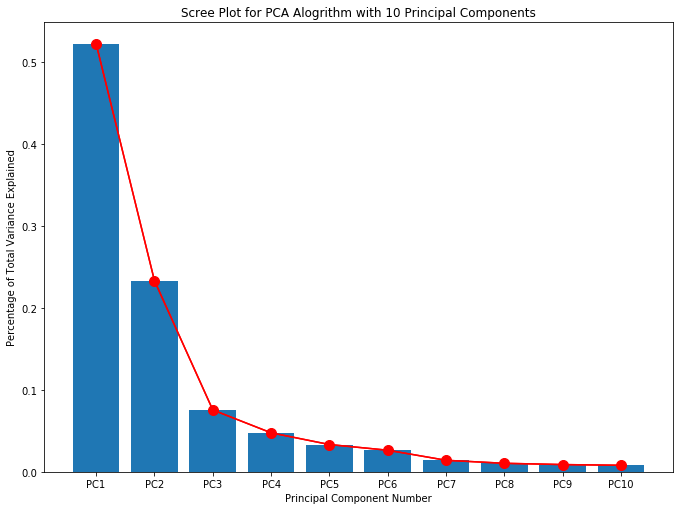

In [9]:
plt.figure(figsize=(11.27,8.27))
plt.bar(x='PC', height='var', data=var_)
plt.plot(var_['PC'], var_['var'], color='red')
plt.plot(var_['PC'], var_['var'], marker='o', markersize=10, color='red')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Total Variance Explained')
plt.title('Scree Plot for PCA Alogrithm with 10 Principal Components')
plt.show()

Find all principal components to keep by looping through until we hit our target of 80%

In [14]:
to_keep = []
count = 0
target = .85
while target >= 0:
    target = target - var_.iloc[count, 0]
    to_keep.append(var_.iloc[count, 1])
    count += 1

In [15]:
pc_to_keep = pd.DataFrame([x[:len(to_keep)] for x in features_PCA], columns=['PC1', 'PC2', 'PC3', 'PC4'])

Z-scale principal componenets

In [16]:
pc_to_keep_z = pc_to_keep.apply(stats.zscore)

Now that each record has a "score" in each dimension, create a function to sum those scores which will define each records fraud score

In [17]:
def euc_sum(vals):
    return (np.abs(sum([x**2 for x in vals])))**(1/2)

In [18]:
pc_to_keep_z['SUM'] = pc_to_keep_z.apply(euc_sum, axis=1)

In [19]:
pc_to_keep_z

,PC1,PC2,PC3,PC4,SUM
0,0.000939,-0.090230,-0.081992,-0.063785,0.137599
1,4.199913,16.128732,5.241872,1.222970,17.514227
2,0.006287,0.064573,-0.043461,0.010342,0.078772
3,0.044381,-0.074404,-0.043499,-0.079560,0.125409
4,9.410793,-4.801232,2.740579,-12.562188,16.641340
...,...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526,0.078142
1070990,-0.035513,-0.078378,-0.031540,-0.002969,0.091695
1070991,-0.030828,-0.080535,-0.027994,0.000618,0.090666
1070992,-0.021493,-0.065886,-0.013105,-0.014869,0.072081


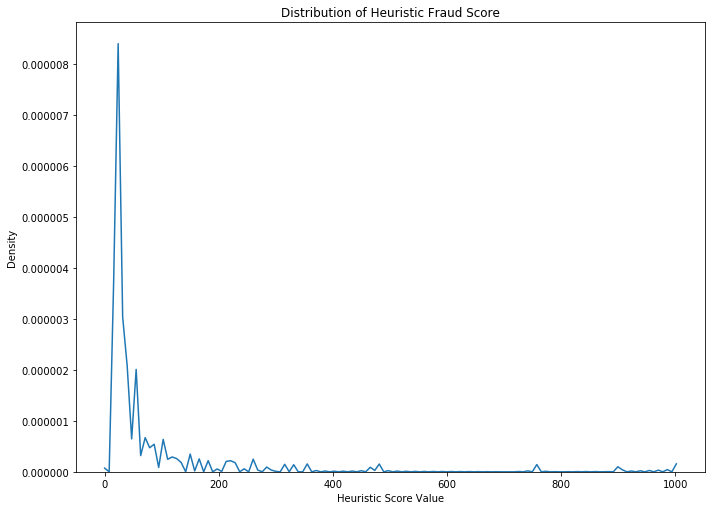

In [20]:
plt.figure(figsize=(11.27, 8.27))
sns.kdeplot(pc_to_keep_z['SUM'], legend=False)
plt.title('Distribution of Heuristic Fraud Score')
plt.xlabel('Heuristic Score Value')
plt.ylabel('Density')
plt.show()

# Model 2: Autoencoder

Build autoencoder using z-scaled PCs from previous model

In [21]:
enc = pc_to_keep_z.drop('SUM', axis=1)

In [22]:
enc

,PC1,PC2,PC3,PC4
0,0.000939,-0.090230,-0.081992,-0.063785
1,4.199913,16.128732,5.241872,1.222970
2,0.006287,0.064573,-0.043461,0.010342
3,0.044381,-0.074404,-0.043499,-0.079560
4,9.410793,-4.801232,2.740579,-12.562188
...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526
1070990,-0.035513,-0.078378,-0.031540,-0.002969
1070991,-0.030828,-0.080535,-0.027994,0.000618
1070992,-0.021493,-0.065886,-0.013105,-0.014869


In [25]:
inp = Input(shape=(enc.shape[1], ))
encode = Dense(20, input_shape=(enc.shape, ), activation='relu')(inp)
encode = Dense(10, activation='relu')(encode)
decode = Dense(20, activation='relu')(encode)
decode = Dense(enc.shape[1], activation='relu')(decode)
model = Model(inputs=inp, outputs=decode)

In [26]:
callbacks = [EarlyStopping(patience=5, monitor='mean_squared_error', verbose=1),
             ModelCheckpoint('alex_best_model.h5', monitor='mean_squared_error', save_best_only=True, verbose=1)]

In [27]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])

history = model.fit(enc, enc,
                    epochs=30,
                    callbacks=callbacks)

Epoch 1/30
1070994/1070994 [==============================] - 16s 15us/step - loss: 0.5646 - mean_squared_error: 0.5647ETA: 3s - loss: 0.2841 - mean_squared_error: 0.2841

Epoch 00001: mean_squared_error improved from inf to 0.56465, saving model to alex_best_model.h5
Epoch 2/30
1070994/1070994 [==============================] - 16s 15us/step - loss: 0.4560 - mean_squared_error: 0.4560ETA: 5s - loss: 0.3927 - mean_squared_error: 0.3927

Epoch 00002: mean_squared_error improved from 0.56465 to 0.45600, saving model to alex_best_model.h5
Epoch 3/30
1070994/1070994 [==============================] - 16s 15us/step - loss: 0.4787 - mean_squared_error: 0.4787ETA: 9s - loss: 0.8325 - mean_squared_error: 0.8325  - ETA: 1s - loss: 0.5251 - mean_squared_error: 0.5250

Epoch 00003: mean_squared_error did not improve from 0.45600
Epoch 4/30
1070994/1070994 [==============================] - 16s 15us/step - loss: 0.3617 - mean_squared_error: 0.3616

Epoch 00004: mean_squared_error improved from 0.4

In [28]:
model.load_weights('alex_best_model.h5')

In [29]:
preds = model.predict(enc)
enc_array = np.array(enc)

In [30]:
def rep_error(z, z_):
    return (np.sum((np.abs(np.subtract(z, z_))**2)))**(1/2)

error_lambda = lambda x, y: rep_error(x, y)

In [31]:
rep_error = list(map(error_lambda, enc_array, preds))

In [32]:
enc['REP_ERROR'] = rep_error

In [33]:
enc

,PC1,PC2,PC3,PC4,REP_ERROR
0,0.000939,-0.090230,-0.081992,-0.063785,0.137599
1,4.199913,16.128732,5.241872,1.222970,3.258095
2,0.006287,0.064573,-0.043461,0.010342,0.045817
3,0.044381,-0.074404,-0.043499,-0.079560,0.125409
4,9.410793,-4.801232,2.740579,-12.562188,14.015532
...,...,...,...,...,...
1070989,-0.031661,-0.063996,-0.027697,0.015526,0.078142
1070990,-0.035513,-0.078378,-0.031540,-0.002969,0.091695
1070991,-0.030828,-0.080535,-0.027994,0.000618,0.090666
1070992,-0.021493,-0.065886,-0.013105,-0.014869,0.072081


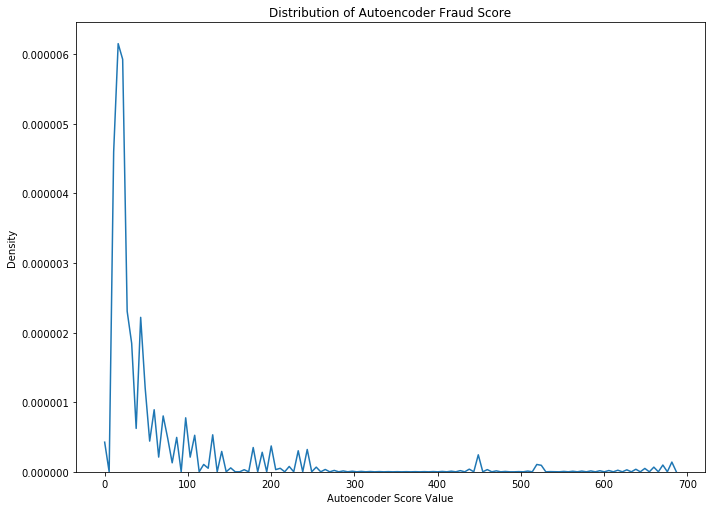

In [38]:
plt.figure(figsize=(11.27, 8.27))
sns.kdeplot(enc['REP_ERROR'], legend=False)
plt.title('Distribution of Autoencoder Fraud Score')
plt.xlabel('Autoencoder Score Value')
plt.ylabel('Density')
plt.show()

# Fraud Score Visualizations and Final Score Computation

In [39]:
results_df = pd.merge(pc_to_keep_z, enc.drop(['PC1', 'PC2', 'PC3', 'PC4'],axis=1),
                      left_index=True, right_index=True)

In [40]:
results_df['FINAL_SCORE'] = (results_df['SUM'] + results_df['REP_ERROR']) / 2

In [41]:
results_df['FINAL_SCORE']

0           0.137599
1          10.386161
2           0.062294
3           0.125409
4          15.328436
             ...    
1070989     0.078142
1070990     0.091695
1070991     0.090666
1070992     0.072081
1070993     0.048128
Name: FINAL_SCORE, Length: 1070994, dtype: float64

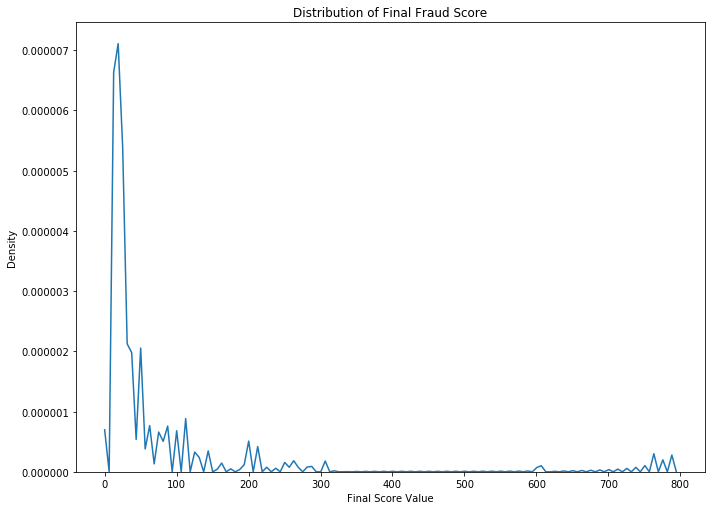

In [42]:
plt.figure(figsize=(11.27, 8.27))
sns.kdeplot(results_df['FINAL_SCORE'], legend=False)
plt.title('Distribution of Final Fraud Score')
plt.xlabel('Final Score Value')
plt.ylabel('Density')
plt.show()

## Binning method 1: Quantile Binning

In [71]:
results_df_sorted = results_df.sort_values('FINAL_SCORE', ascending=True)
results_df_sorted['q_bins'] = pd.qcut(results_df_sorted['FINAL_SCORE'], q=20, labels=list(map(str, range(1, 21))))

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

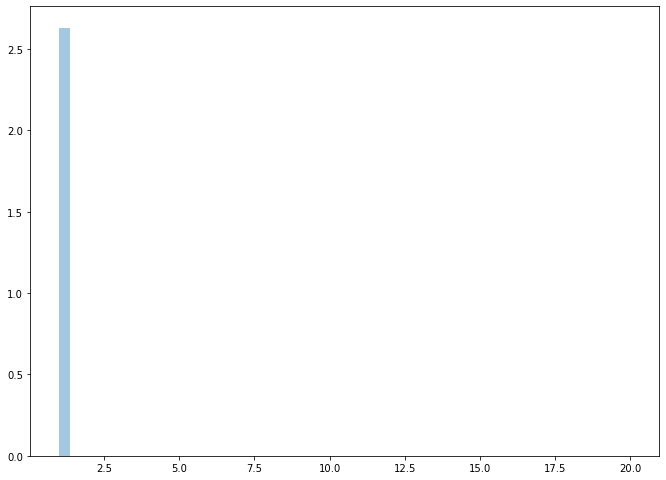

In [81]:
plt.figure(figsize=(11.27, 8.27))
kde = sns.kdeplot(results_df['q_bins'], legend=False)
kde.set_xticks(results_df['q_bins'])
kde.set_xticklabels(results_df['q_bins'].values)
plt.title('Distribution of Final Fraud Score')
plt.xlabel('Final Score Value')
plt.ylabel('Density')
plt.show()

In [72]:
results_df.to_csv('alex_results.csv')

In [73]:
results_df_sorted['q_bins'].unique()

[1, 2, 3, 4, 5, ..., 16, 17, 18, 19, 20]
Length: 20
Categories (20, object): [1 < 2 < 3 < 4 ... 17 < 18 < 19 < 20]